# MAX IV VERITAS data analysis

# Initialisation

In [682]:
# %% =========================== basic imports =========================== %% #
import sys
sys.path.insert(0, 'brixs-main/')
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np


# %% =========================== brixs imports =========================== %% #
#### The following two lines are only necessary if you are importing brixs 
#### from a local file
# import sys
# sys.path.insert(0, 'brixs-main/')
import brixs as br
import brixs.beamlines.veritas as veritas

# %% ============================== settings ============================= %% #
# matplotlib (optional)
# get_ipython().run_line_magic('matplotlib', 'qt5')
# get_ipython().run_line_magic('matplotlib', 'tk')
# get_ipython().run_line_magic('matplotlib', 'notebook') # switch to inline plotting
plt.ion()

# %% ============================= folderpaths =========================== %% #
# the path to the top/main folder is going to be used constantly, so we are better
# off defining a variable for it
# TOP = Path(r'veritas\veritas')
TOP = Path(r'/data/visitors/veritas/20250727/2025110508')
RAW = TOP/'raw'
# OUT = Path('Work/experiments/MaxIV with Zhen/VERITAS_test/out')
OUT = Path.cwd()/'out'

DLD = RAW/'20251105_RIXS1.h5'
XAS = RAW/'20251105_scans1.h5'



# %% adding rixs spectra
# define rixs processing parameters
mask0 = ([1041, 6000, 1950, 3780], [1041, 6000, 4330, 5930])
time  = dict(tcutoff=3e7, tnbins=10000, period=1458, twidth=320, tcenter='max')
curv  = [0, -0.04, 0]
calib = 0.002119402
sbins = 1200
parameters = dict(filepath=DLD, mask=mask0, curv=curv, calib=calib, sbins=sbins)
parameters.update(**time)

In [12]:
sys.path

['brixs-main/',
 'brisx-main/',
 'brisx-main/',
 'brisx-main/',
 '/opt/conda/lib/python312.zip',
 '/opt/conda/lib/python3.12',
 '/opt/conda/lib/python3.12/lib-dynload',
 '',
 '/opt/conda/lib/python3.12/site-packages']

# Template

## 1.1 RIXS verification

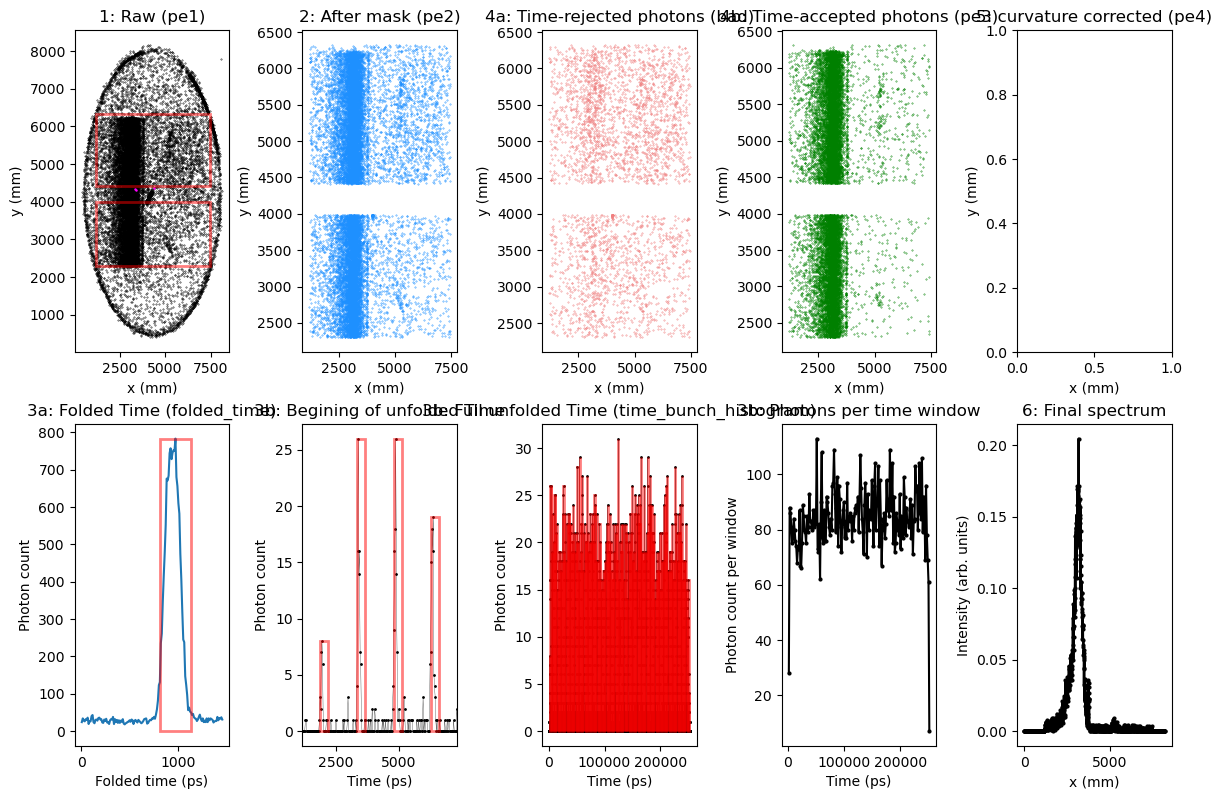

In [14]:
# %% quickly verify detector data processing step-by-step (without curvature correction)
scan = 216
mask0 = ([1194, 7442, 2300, 3988], [1194, 7442, 4415, 6325])  # mask
time  = dict(tcutoff=3e7, tnbins=10000, period=1458, twidth=320, tcenter='max')
sbins = 1200

_ = veritas.verify(scan, DLD, mask=mask0, sbins=sbins, **time, figsize=(30,20))
# %%

## 1.2 Curvature

curv = [np.float64(-9.453582907922222e-07), np.float64(-0.007860465116278997), 0]


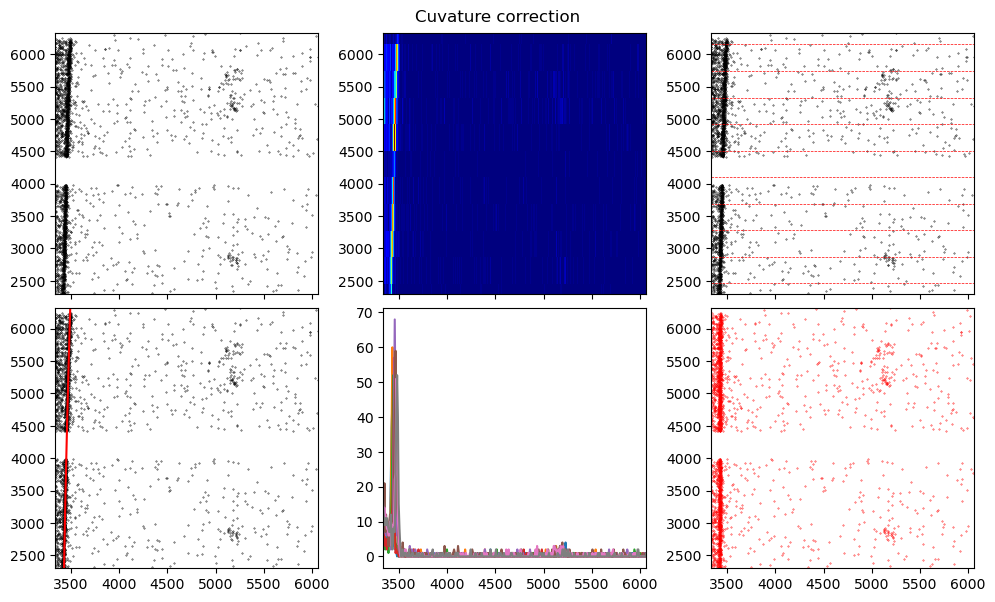

In [386]:
# %% calculating the curvature
scan  = 395

mask0 = ([1194, 7442, 2300, 3988], [1194, 7442, 4415, 6325])
time = dict(tcutoff=3e7, tnbins=10000, period=1458, twidth=320, tcenter='max')
nbins = (20, 1000)

curv = veritas.verify_curvature_correction(scan, DLD3, mask=mask0, nbins=nbins, **time, figsize=(25,15))
print(f'curv = {list(curv[:2]) + [0]}')
# br.zoom(5500, 6000)
# %%

## 1.3 Energy calibration

Text(0.5, 0, 'photon hit')

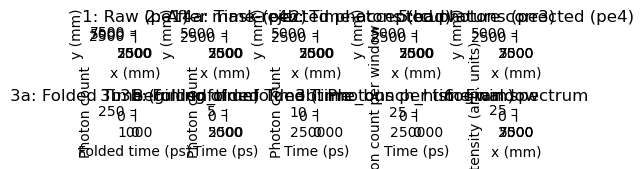

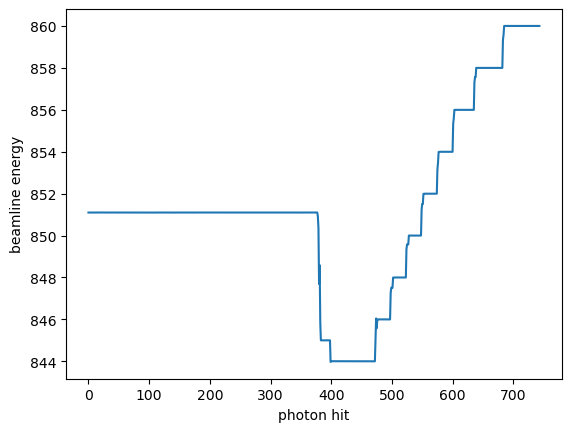

In [76]:
# %% Energy calibration
scan = 48
mask0 = ([1194, 7442, 2300, 3988], [1194, 7442, 4415, 6325])
time = dict(tcutoff=3e7, tnbins=10000, period=1458, offset=None, twidth=320, tcenter='max')
curv  = [0, -0.0273, 0]

# plot for verification
_ = veritas.verify(scan, DLD, mask=mask0, curv=curv, sbins=1200, **time)

# calculate energy calibration via scipy (alternatively, one can also calculate it by hand)
from scipy.signal import find_peaks

# include raw energies as a metadata
veritas.rixs_attrs['raw']['E_raw'] = 'External/beamline_energy/position'

# get spectrum
s = veritas.process(scan, DLD, mask=mask0, curv=curv, sbins=1200, **time)


# delete added metadata so we don't load it anymore for future scans
del veritas.rixs_attrs['raw']['E_raw']

# plot energies
br.figure()
plt.plot(s.E_raw[:, 1])
plt.ylabel('beamline energy')
plt.xlabel('photon hit')

calib =  0.004024336330358059


Text(0, 0.5, 'photon energy')

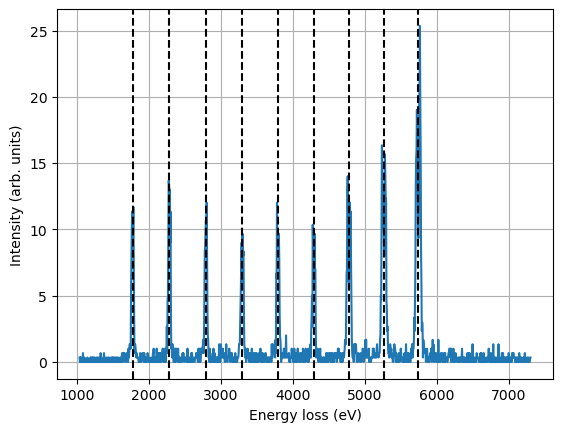

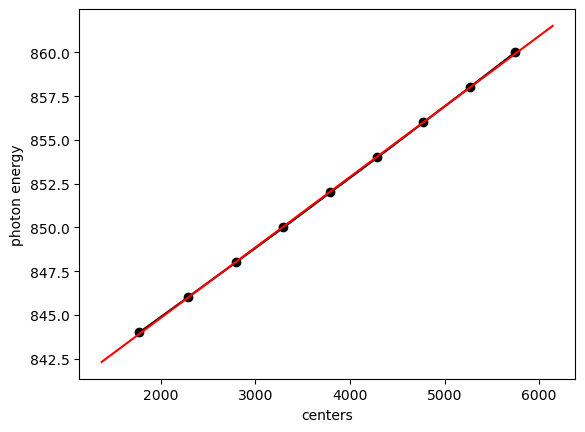

In [86]:
# get energies from plot (or from logbook)
energies = [844, 846, 848, 850, 852, 854, 856, 858, 860]
energies = br.sort(energies, energies)

# find peaks (can also be done manually)
temp, _ = find_peaks(s.y, height=5, distance=50)
centers = [s.x[_] for _ in temp]

# fit peaks to get accurate peak centers
final = []
for center in centers:
    fit, popt, sigma, model = s.fit_peak(limits=(center-200, center+200))
    final.append(popt[1])

# plot for verification
br.figure()
s.plot()
br.axvlines(final, color='black')
br.labels.rixs()

# calibration value
s = br.Spectrum(x=final, y=energies)
fit, popt, r2, model = s.polyfit(deg=1)
print('calib = ', popt[0])

# plot for verification
br.figure()
s.plot(marker='o', color='black')
fit.plot(color='red')
plt.xlabel('centers')
plt.ylabel('photon energy')
# %%

## 1.4 Plotting and Adding RIXS spectra

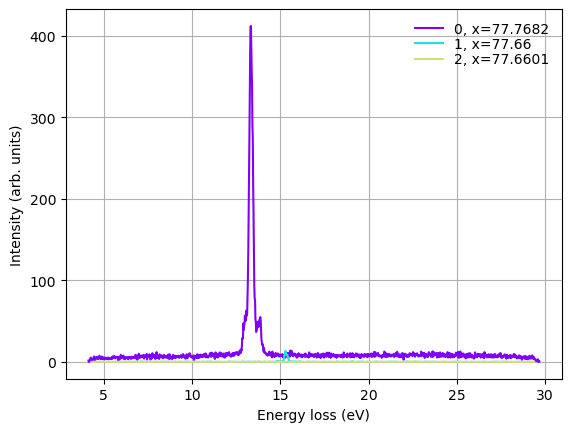

In [285]:
# %% Plotting several rixs spectra
# define rixs processing parameters
mask0 = ([1194, 7442, 2300, 3988], [1194, 7442, 4415, 6325])
time  = dict(tcutoff=3e7, tnbins=10000, period=1458, twidth=320, tcenter='max')
curv  = [0, -0.0273, 0]
calib = 0.004024336330358059
sbins = 1200
parameters = dict(filepath=DLD, mask=mask0, curv=curv, calib=calib, sbins=sbins)
parameters.update(**time)

# read scans
scans = [0, 1, 2]

ss = br.Spectra()
for i, scan in enumerate(scans):
    _s = veritas.process(scan, **parameters)
    motor_x = round(_s.sample_x, 4)
    _s.label = f'{_s.scan}, x={motor_x}'
    ss.append(_s)

# plot
colors = br.get_colors_from_colormap('rainbow', len(ss))
br.figure()
ss.plot(color=colors)
br.leg()
br.labels.rixs()

In [ ]:
# align and calculate sum (or average)
ss2 = ss.interp().align().set_shift(-7.853)
s2  = ss2.calculate_average()
s2.label = 'Average'

# plot
br.figure()
ss2.plot(color=colors)
s2.plot(color='black')
br.leg()
br.labels.rixs()
br.zoom(-7, 1)
# %%

## 1.5 RIXS map

In [282]:
# %% energy map
# define rixs processing parameters
mask0 = ([1041, 6000, 1950, 3780], [1041, 6000, 4330, 5930])
time  = dict(tcutoff=3e7, tnbins=10000, period=1458, twidth=320, tcenter='max')
curv  = [0, -0.04, 0]
calib = 0.002119402
sbins = 1200
parameters = dict(filepath=DLD, mask=mask0, curv=curv, calib=calib, sbins=sbins)
parameters.update(**time)

# read scans
scans = [302, 303, 304, 306]

# let's pretend this scan sequence is a energy map
ss = br.Spectra()
# energies = []  # uncomment this for real energy map     
for i, scan in enumerate(scans):
    _s = veritas.process(scan, **parameters)
    # energies.append(round(_s.E, 2))  # uncomment this for real energy map
    ss.append(_s)
energies = np.linspace(575, 576, len(scans))  # comment this out for real energy map

# align spectra (sometimes, it must be done mannualy)
# ss2 = ss[i].set_shift(value)  # manually 
ss2 = ss.interp().align().set_shift(-7.853)

# create image
im  = ss2.stack_spectra_as_columns()
im.x_centers = energies

AssertionError: scan 302 not found in file /data/visitors/veritas/20250727/2025110508/raw/20251105_RIXS1.h5

Scan available: [0, 1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 11, 110, 111, 112, 113, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

In [ ]:
# plot
br.figure()
im.plot()
br.labels.energy_map()
plt.ylim(-6, 1)
# %%

## 1.6 XAS

In [ ]:
# %% plot multiple xas divided by I0, floored, and normalized
scans = (197, 198)

fig, axes = br.subplots(1, 3, layout='constrained', sharex=True, sharey=True)
for scan in scans:
    MCP, TEY, TFY, RMU = veritas.read(scan, XAS)
    MCP = MCP/RMU
    TFY = TFY/RMU
    TEY = TEY/RMU

    MCP.floor(limits=(565, 570)).normalize(1, limits=(591, 595)).plot(ax=axes[0], label=f'{scan}')
    TFY.floor(limits=(565, 570)).normalize(1, limits=(591, 595)).plot(ax=axes[1])
    TEY.floor(limits=(565, 570)).normalize(1, limits=(591, 595)).plot(ax=axes[2])

br.leg(ax=axes[0])
plt.suptitle('xas')
#axes[0].set_ylim([0,2])
# axes[1].set_ylim([0,2])
br.zoom(840,890, ax=axes[1])
br.labels.xas('MCP', ax=axes[0])
br.labels.xas('TFY', ax=axes[1])
br.labels.xas('TEY', ax=axes[2])

## 1.7 motor scans

In [ ]:
# %% linescan
scan = 145
MCP, TEY, TFY, RMU = veritas.read(scan, XAS)
     
# plot
br.figure()
(TEY/RMU).plot()

plt.grid()
plt.ylabel('TEY')0.0040241337206320124
plt.xlabel(TEY.scanned_motors[0])

## 1.8 mesh

In [ ]:
# %% mesh scan
# Mesh scan have two profiles, stairs and snake
# This code only works for stairs
#          ┌──── b       /\        a
#          |            /  \      /
#     ┌────┘           /    \    /
#     |               /      \  /
# ────┘              /        \/
scan = 211
MCP, TEY, TFY, RMU = veritas.read(scan, XAS)

# this scan was done with this command
print(TEY.command)

# use the following lines to flip the image if necessary
# TEY = TEY.flipx()
TEY = TEY.flipy()

# plot
fig, axes = br.subplots(1, 3, layout='constrained', figsize=(25,15))

TEY.pcolormesh(ax=axes[0], colorbar=True)
TFY.pcolormesh(ax=axes[1], colorbar=True)
MCP.pcolormesh(ax=axes[2], colorbar=True)

axes[0].set_title('TEY')
axes[1].set_title('TFY')
axes[2].set_title('MCP')
# %%

# Tutorial

In [683]:
# Initialise calibration parameters and file paths

mask0 = ([1194, 7442, 2300, 3988], [1194, 7442, 4415, 6325])
time  = dict(tcutoff=3e7, tnbins=10000, period=1458, twidth=320, tcenter='max')
calib = 0.004024336330358059
sbins = 1200
parameters = dict(filepath=DLD3, mask=mask0, calib=calib, sbins=sbins)
parameters.update(**time)
DLD3= RAW/'20251107_RIXS3.h5'
rixspath = DLD

'S118, energy = 850.7 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

(-85337462.83791226, 1792086719.5961573)

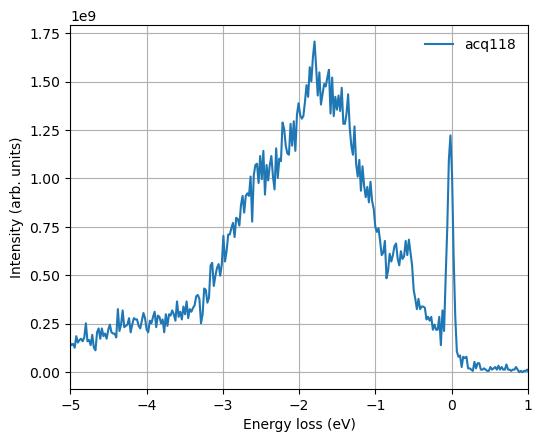

In [295]:
# read one scan

# insert ONE acquisition number
scan = 118

# curvature correction
curv = veritas.verify_curvature_correction(scan, rixspath, mask=mask0, nbins=nbins, **time, figsize=(25,15))
plt.close() # disable this line to inspect curvature correction
parameters.update(curv=curv, filepath = rixspath)

# process RIXS
s = veritas.process(scan, **parameters)

# Normalise by beam current ('I/0')
_I0 = veritas.get_metadata(scan, rixspath, 'External/aemexp2_ch1/InstantCurrent')
_I0 = np.mean(_I0[:, 1])
s = s/_I0

# set horizontal, vertical shifts and multiplicative factor
shift_hor = -14.24
multip = 1
shift_ver = 0
s = s.set_shift(shift_hor).set_factor(multip).set_offset(shift_ver)

# display information about the scan
display(f'S{scan}, energy = {s.E} eV, sample rotation = {s.th_veritas} deg, scattering angle = {s.tth} deg')

# create figure and change figure size
br.figure(figsize=(15, 12))

# plot
s.plot(label=f'acq{scan}')
br.leg()
br.labels.rixs()

# change axes limits
plt.xlim([-5, 1])
plt.ylim([None, None])

'loading S118, energy = 850.7 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S117, energy = 850.6 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S119, energy = 850.8 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

(-85963299.92136204, 1805229298.3486028)

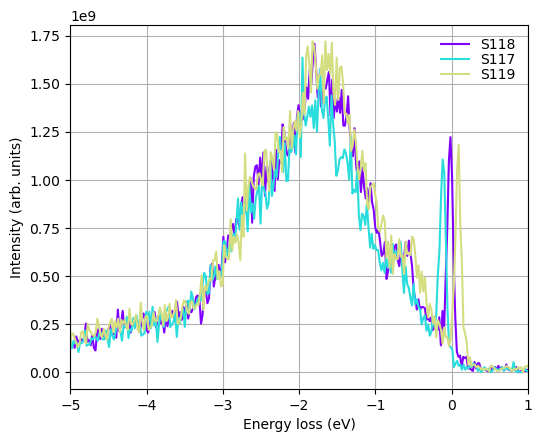

In [333]:
# plot more than one scans on the same axes

# insert several acquisition numbers
scans =[118, 117, 119]

# set horizontal shift
shift_hor = -14.24

ss = br.Spectra()
for i, scan in enumerate(scans):
    curv = veritas.verify_curvature_correction(scans[0], rixspath, mask=mask0, nbins=nbins, **time, figsize=(25,15))
    plt.close()
    parameters.update(curv=curv, filepath = rixspath)
    _s = veritas.process(scan, **parameters)
    _I0 = veritas.get_metadata(scan, rixspath, 'External/aemexp2_ch1/InstantCurrent')
    _I0 = np.mean(_I0[:, 1])
    _s = _s/_I0
    _s = _s.set_shift(shift_hor)
    _s.label = f'S{scan}'
    display(f'loading S{scan}, energy = {_s.E} eV, sample rotation = {_s.th_veritas} deg, scattering angle = {_s.tth} deg')
    ss.append(_s)

# plot
colors = br.get_colors_from_colormap('rainbow', len(ss))
br.figure(figsize=(15, 12))
ss.plot(color=colors)
br.leg()
# br.leg(['850.7 eV', '850.6 eV', '850.8 eV']) # create custom legends
br.labels.rixs()

# change axes limits
plt.xlim([-5, 1])
plt.ylim([None, None])

'loading S118, energy = 850.7 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S117, energy = 850.6 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S119, energy = 850.8 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

(-85001781.1173495, 1785037403.4643397)

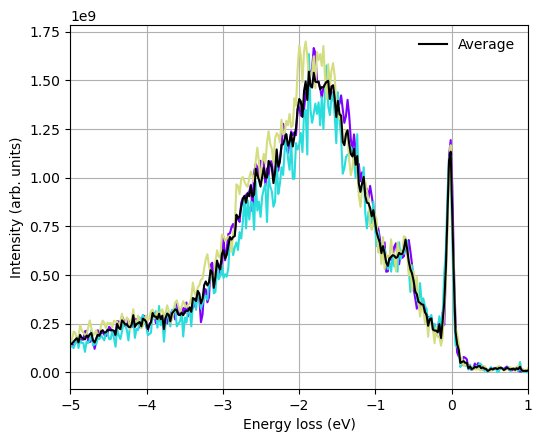

In [299]:
# Combine several acquisitions with same or similar conditions into one spectrum

# insert several acquisition numbers
# Note that all the spectra will be aligned with the FIRST ONE.
scans =[118, 117, 119]

# set horizontal shift (based on the FIRST acquisition in the list above)
shift_hor = -14.24

_ss = br.Spectra()
for i, scan in enumerate(scans):
    curv = veritas.verify_curvature_correction(scans[0], rixspath, mask=mask0, nbins=nbins, **time, figsize=(25,15))
    plt.close()
    parameters.update(curv=curv, filepath = rixspath)
    _s = veritas.process(scan, **parameters)
    _I0 = veritas.get_metadata(scan, rixspath, 'External/aemexp2_ch1/InstantCurrent')
    _I0 = np.mean(_I0[:, 1])
    _s = _s/_I0
    display(f'loading S{scan}, energy = {_s.E} eV, sample rotation = {_s.th_veritas} deg, scattering angle = {_s.tth} deg')
    _ss.append(_s)

# align and calculate average
ss = _ss.interp().align().set_shift(shift_hor)
# ss = _ss.interp().align(limits=(14, 15)).set_shift(shift_hor) # you can also set up a correlation range if general alignment does not work
s = ss.calculate_average()
s.label = 'Average'

# plot
colors = br.get_colors_from_colormap('rainbow', len(ss))
br.figure(figsize=(15, 12))
ss.plot(color=colors)
s.plot(color='black')
br.leg()
br.labels.rixs()

# change axes limits
plt.xlim([-5, 1])
plt.ylim([None, None])

'loading S118, energy = 850.7 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S117, energy = 850.6 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S119, energy = 850.8 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S127, energy = 851.6 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S128, energy = 851.7 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S129, energy = 851.8 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S137, energy = 852.6 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

(-170442130.6383673, 3579284743.4057126)

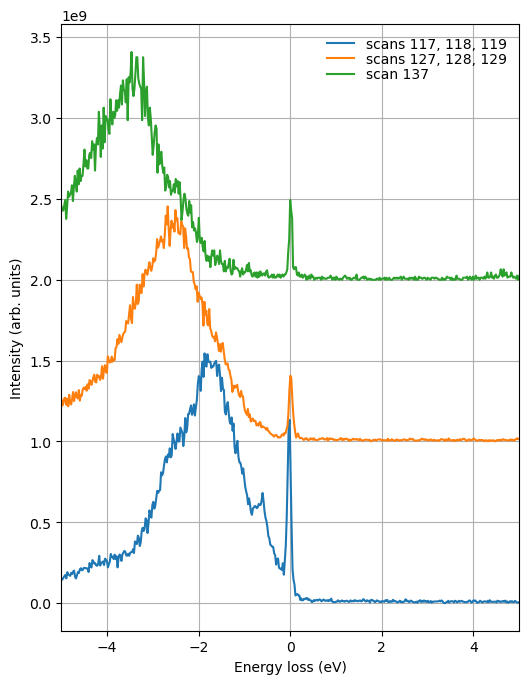

In [355]:
# Combine several sets of spectra and plot on the same graph

# First set of spectra
scans =[118, 117, 119]
_ss = br.Spectra()
for i, scan in enumerate(scans):
    curv = veritas.verify_curvature_correction(scans[0], rixspath, mask=mask0, nbins=nbins, **time, figsize=(25,15))
    plt.close()
    parameters.update(curv=curv, filepath = rixspath)
    _s = veritas.process(scan, **parameters)
    _I0 = veritas.get_metadata(scan, rixspath, 'External/aemexp2_ch1/InstantCurrent')
    _I0 = np.mean(_I0[:, 1])
    _s = _s/_I0
    display(f'loading S{scan}, energy = {_s.E} eV, sample rotation = {_s.th_veritas} deg, scattering angle = {_s.tth} deg')
    _ss.append(_s)
_ss = _ss.interp().align()
s1 = _ss.calculate_average()
s1 = s1.set_shift(-14.24) # set horizontal shift
s1.label = f'scans 117, 118, 119' # set label

# Second set of spectra
scans = np.arange(127, 129+1)
_ss = br.Spectra()
for i, scan in enumerate(scans):
    curv = veritas.verify_curvature_correction(scans[0], rixspath, mask=mask0, nbins=nbins, **time, figsize=(25,15))
    plt.close()
    parameters.update(curv=curv, filepath = rixspath)
    _s = veritas.process(scan, **parameters)
    _I0 = veritas.get_metadata(scan, rixspath, 'External/aemexp2_ch1/InstantCurrent')
    _I0 = np.mean(_I0[:, 1])
    _s = _s/_I0
    display(f'loading S{scan}, energy = {_s.E} eV, sample rotation = {_s.th_veritas} deg, scattering angle = {_s.tth} deg')
    _ss.append(_s)
_ss = _ss.interp().align(limits=(14, 16)) # you can set up a correlation range if general alignment does not work
s2 = _ss.calculate_average()
s2 = s2.set_shift(-15.04) # set horizontal shift
s2.label = f'scans 127, 128, 129' # set label

# Third set of spectra
scans = [137]
_ss = br.Spectra()
for i, scan in enumerate(scans):
    curv = veritas.verify_curvature_correction(scans[0], rixspath, mask=mask0, nbins=nbins, **time, figsize=(25,15))
    plt.close()
    parameters.update(curv=curv, filepath = rixspath)
    _s = veritas.process(scan, **parameters)
    _I0 = veritas.get_metadata(scan, rixspath, 'External/aemexp2_ch1/InstantCurrent')
    _I0 = np.mean(_I0[:, 1])
    _s = _s/_I0
    display(f'loading S{scan}, energy = {_s.E} eV, sample rotation = {_s.th_veritas} deg, scattering angle = {_s.tth} deg')
    _ss.append(_s)
_ss = _ss.interp().align()
s3 = _ss.calculate_average()
s3 = s3.set_shift(-16.13) # set horizontal shift
s3.label = f'scan 137' # set label

# plot
br.figure(figsize=(15, 20))
s1.set_factor(1).set_offset(0).plot() # set multiplicative factor, vertical shift (if required)
s2.set_factor(1).set_offset(1e9).plot() # set multiplicative factor, vertical shift
s3.set_factor(1).set_offset(2e9).plot() # set multiplicative factor, vertical shift
br.leg()
br.labels.rixs()

# change axes limits
plt.xlim([-5, 5])
plt.ylim([None, None])


'loading S118, energy = 850.7 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S117, energy = 850.6 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S119, energy = 850.8 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S127, energy = 851.6 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S128, energy = 851.7 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S129, energy = 851.8 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

'loading S137, energy = 852.6 eV, sample rotation = 306.0 deg, scattering angle = 144.85 deg'

Text(0.5, 0, 'my xlabel')

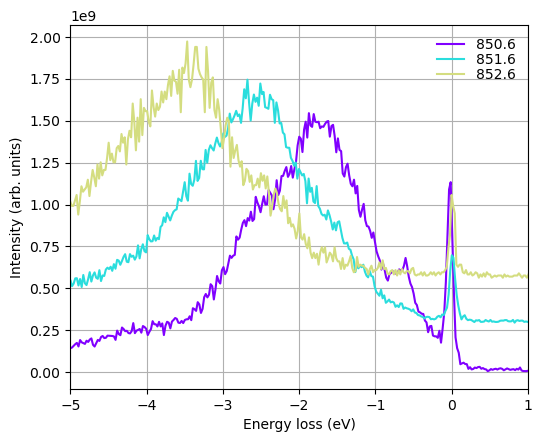

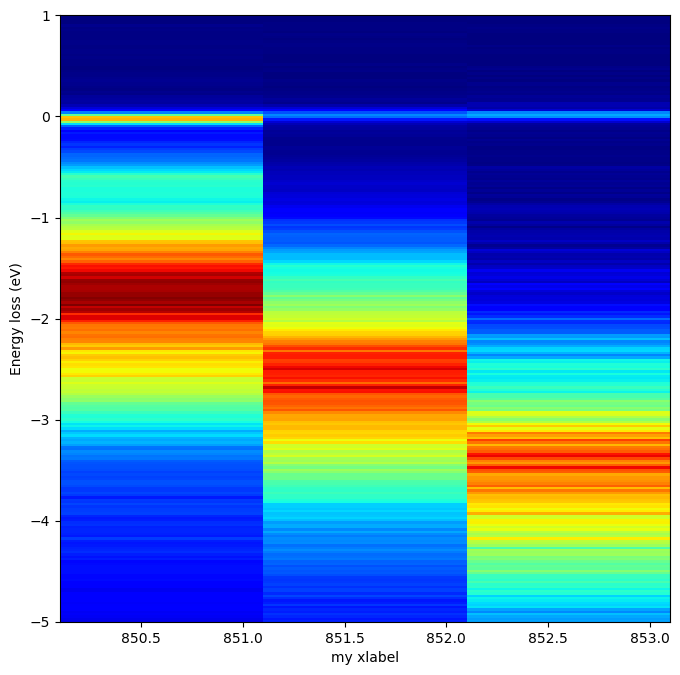

In [361]:
# Plot map

ss = br.Spectra()

# set up the horizontal axis of the map
qq = [850.6, 851.6, 852.6]

# First set of spectra
scans =[118, 117, 119]
_ss = br.Spectra()
for i, scan in enumerate(scans):
    curv = veritas.verify_curvature_correction(scans[0], rixspath, mask=mask0, nbins=nbins, **time, figsize=(25,15))
    plt.close()
    parameters.update(curv=curv, filepath = rixspath)
    _s = veritas.process(scan, **parameters)
    _I0 = veritas.get_metadata(scan, rixspath, 'External/aemexp2_ch1/InstantCurrent')
    _I0 = np.mean(_I0[:, 1])
    _s = _s/_I0
    display(f'loading S{scan}, energy = {_s.E} eV, sample rotation = {_s.th_veritas} deg, scattering angle = {_s.tth} deg')
    _ss.append(_s)
_ss = _ss.interp().align()
_s = _ss.calculate_average()
_s = _s.set_shift(-14.24) # set horizontal shift
_s.label = qq[0] # set label
ss.append(_s)

# Second set of spectra
scans = np.arange(127, 129+1)
_ss = br.Spectra()
for i, scan in enumerate(scans):
    curv = veritas.verify_curvature_correction(scans[0], rixspath, mask=mask0, nbins=nbins, **time, figsize=(25,15))
    plt.close()
    parameters.update(curv=curv, filepath = rixspath)
    _s = veritas.process(scan, **parameters)
    _I0 = veritas.get_metadata(scan, rixspath, 'External/aemexp2_ch1/InstantCurrent')
    _I0 = np.mean(_I0[:, 1])
    _s = _s/_I0
    display(f'loading S{scan}, energy = {_s.E} eV, sample rotation = {_s.th_veritas} deg, scattering angle = {_s.tth} deg')
    _ss.append(_s)
_ss = _ss.interp().align(limits=(14, 16))
_s = _ss.calculate_average()
_s = _s.set_shift(-15.04) # set horizontal shift
_s.label = qq[1] # set label
ss.append(_s)

# Third set of spectra
scans = [137]
_ss = br.Spectra()
for i, scan in enumerate(scans):
    curv = veritas.verify_curvature_correction(scans[0], rixspath, mask=mask0, nbins=nbins, **time, figsize=(25,15))
    plt.close()
    parameters.update(curv=curv, filepath = rixspath)
    _s = veritas.process(scan, **parameters)
    _I0 = veritas.get_metadata(scan, rixspath, 'External/aemexp2_ch1/InstantCurrent')
    _I0 = np.mean(_I0[:, 1])
    _s = _s/_I0
    display(f'loading S{scan}, energy = {_s.E} eV, sample rotation = {_s.th_veritas} deg, scattering angle = {_s.tth} deg')
    _ss.append(_s)
_ss = _ss.interp().align()
_s = _ss.calculate_average()
_s = _s.set_shift(-16.13) # set horizontal shift
_s.label = qq[2] # set label
ss.append(_s)

# cascade plot
colors = br.get_colors_from_colormap('rainbow', len(ss))
br.figure(figsize=(15, 12))
shift_ver_perc = 20 # percentage shift in the vertical direction
ss.plot(color=colors, pvi=shift_ver_perc)
br.leg()
br.labels.rixs()

# change axes limits
plt.xlim([-5, 1])
plt.ylim([None, None])

# create image
im  = ss.interp().stack_spectra_as_columns()
im.x_centers = qq

# colour map
br.figure(figsize=(20,20))
im.plot()
br.labels.energy_map()
plt.ylim(-5, 1)
# plt.clim(0, 2e9) # set colour limits

# add a suitable x label
plt.xlabel('my xlabel')

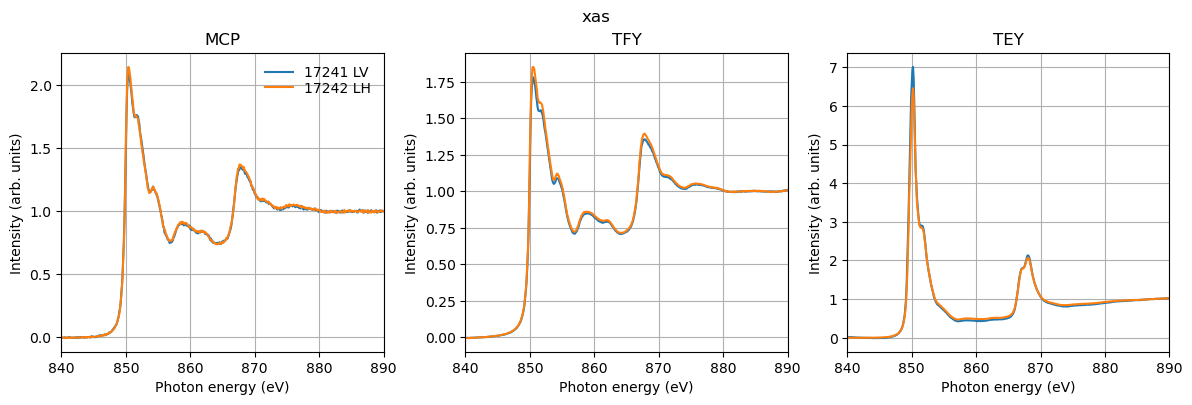

In [88]:
# %% plot multiple xas divided by I0, floored, and normalized

fig, axes = br.subplots(1, 3, layout='constrained', sharex=True, sharey=False, figsize=(30,10))

scans = [17241]
for scan in scans:
    MCP, TEY, TFY, RMU = veritas.read(scan, XAS)
    MCP = MCP/RMU
    TFY = TFY/RMU
    TEY = TEY/RMU

    MCP.floor(limits=(840, 845)).normalize(1, limits=(885, None)).plot(ax=axes[0], label=f'{scan}')
    TFY.floor(limits=(840, 845)).normalize(1, limits=(885, None)).plot(ax=axes[1])
    TEY.floor(limits=(840, 845)).normalize(1, limits=(885, None)).plot(ax=axes[2])

scans = [17242]
for scan in scans:
    MCP, TEY, TFY, RMU = veritas.read(scan, XAS2)
    MCP = MCP/RMU
    TFY = TFY/RMU
    TEY = TEY/RMU

    MCP.floor(limits=(840, 845)).normalize(1, limits=(885, None)).plot(ax=axes[0], label=f'{scan}')
    TFY.floor(limits=(840, 845)).normalize(1, limits=(885, None)).plot(ax=axes[1])
    TEY.floor(limits=(840, 845)).normalize(1, limits=(885, None)).plot(ax=axes[2])

br.leg(['17241 LV', '17242 LH'], ax=axes[0])
plt.suptitle('xas')
#axes[0].set_ylim([0,2])
# axes[1].set_ylim([0,2])
br.zoom(840,890, ax=axes[1])
br.labels.xas('MCP', ax=axes[0])
br.labels.xas('TFY', ax=axes[1])
br.labels.xas('TEY', ax=axes[2])

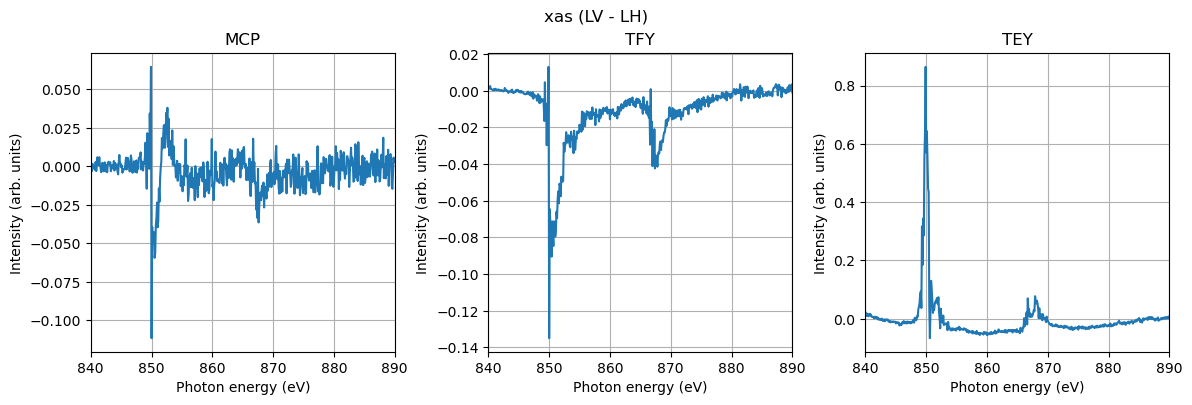

In [436]:
# %% plot multiple xas divided by I0, floored, and normalized

fig, axes = br.subplots(1, 3, layout='constrained', sharex=True, sharey=False, figsize=(30,10))

scans = [17241]
for scan in scans:
    MCP1, TEY1, TFY1, RMU1 = veritas.read(scan, XAS)
    MCP1 = MCP1/RMU1
    TFY1 = TFY1/RMU1
    TEY1 = TEY1/RMU1

    MCP1 = MCP1.floor(limits=(840, 845)).normalize(1, limits=(885, None))
    TFY1 = TFY1.floor(limits=(840, 845)).normalize(1, limits=(885, None))
    TEY1 = TEY1.floor(limits=(840, 845)).normalize(1, limits=(885, None))

scans = [17242]
for scan in scans:
    MCP2, TEY2, TFY2, RMU2 = veritas.read(scan, XAS2)
    MCP2 = MCP2/RMU2
    TFY2 = TFY2/RMU2
    TEY2 = TEY2/RMU2

    MCP2 = MCP2.floor(limits=(840, 845)).normalize(1, limits=(885, None))
    TFY2 = TFY2.floor(limits=(840, 845)).normalize(1, limits=(885, None))
    TEY2 = TEY2.floor(limits=(840, 845)).normalize(1, limits=(885, None))


_ss = br.Spectra()
_ss.append(MCP1)
_ss.append(MCP2)
_ss = _ss.interp()
(_ss[0]-_ss[1]).plot(ax=axes[0])


_ss = br.Spectra()
_ss.append(TFY1)
_ss.append(TFY2)
_ss = _ss.interp()
(_ss[0]-_ss[1]).plot(ax=axes[1])

_ss = br.Spectra()
_ss.append(TEY1)
_ss.append(TEY2)
_ss = _ss.interp()
(_ss[0]-_ss[1]).plot(ax=axes[2])

plt.suptitle('xas (LV - LH)')
#axes[0].set_ylim([0,2])
# axes[1].set_ylim([0,2])
br.zoom(840,890, ax=axes[1])
br.labels.xas('MCP', ax=axes[0])
br.labels.xas('TFY', ax=axes[1])
br.labels.xas('TEY', ax=axes[2])

################# Here begins LV energy map ################

In [51]:
# read scans
mask0 = ([1194, 7442, 2300, 3988], [1194, 7442, 4415, 6325])
time  = dict(tcutoff=3e7, tnbins=10000, period=1458, twidth=320, tcenter='max')
calib = 0.004024336330358059
sbins = 1200
parameters = dict(filepath=DLD, mask=mask0, calib=calib, sbins=sbins)
parameters.update(**time)

scans = [*np.arange(166, 175+1), *[216], *np.arange(177, 215+1)]

# let's pretend this scan sequence is a energy map
ss = br.Spectra()
energies = []  # uncomment this for real energy map 
grad = 1
for i, scan in enumerate(scans):
    curv = veritas.verify_curvature_correction(scan, DLD, mask=mask0, nbins=nbins, **time, figsize=(25,15))
    plt.close()
    parameters.update(curv=curv)
    _s = veritas.process(scan, **parameters)
    if _s.exposure_time != 0:
        _s = _s.set_factor(_s.exposure_time)
    energies.append(round(_s.E, 2))  # uncomment this for real energy map
    _s = _s.set_shift(-13.76-(energies[i]-energies[0])*grad)
    _I0 = veritas.get_metadata(scan, DLD, 'External/aemexp2_ch1/InstantCurrent')
    _I0 = np.mean(_I0[:, 1])
    _s = _s/_I0
    ss.append(_s)
    
# align spectra (sometimes, it must be done mannualy)
# ss2 = ss[i].set_shift(value)  # manually 
# for i, scan in enumerate(scans):
#    # ss2 = ss.interp().align(mode='seq', limits = (-0.5, 5)).set_shift(-13.16)
#    ss2 = ss.set_shift

# create image
# im  = ss2.interp().stack_spectra_as_columns()
im  = ss.interp().stack_spectra_as_columns()
im.x_centers = energies


In [43]:
help(veritas.process)

Help on function process in module brixs.beamlines.veritas.advanced:

process(scan, filepath, mask, tcutoff=30000000.0, tnbins=10000, period=1458, offset=None, twidth=320, tcenter='max', curv=None, curv_nbins=(20, 1000), sbins=1200, calib=None)
    return processed rixs spectrum

    For a complete description of this function, Please refer to
        brixs/examples/beamlines/veritas/rixs.py

    Returns:
        spectrum



(-8.0, 1.0)

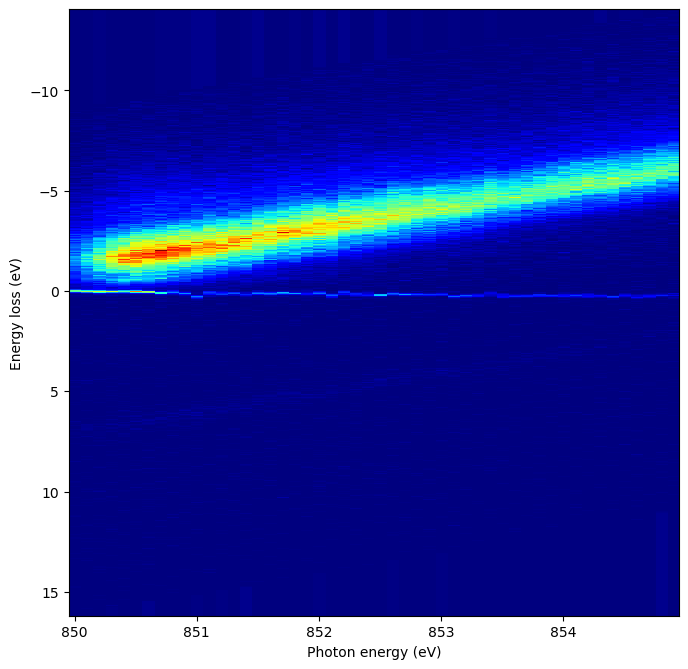

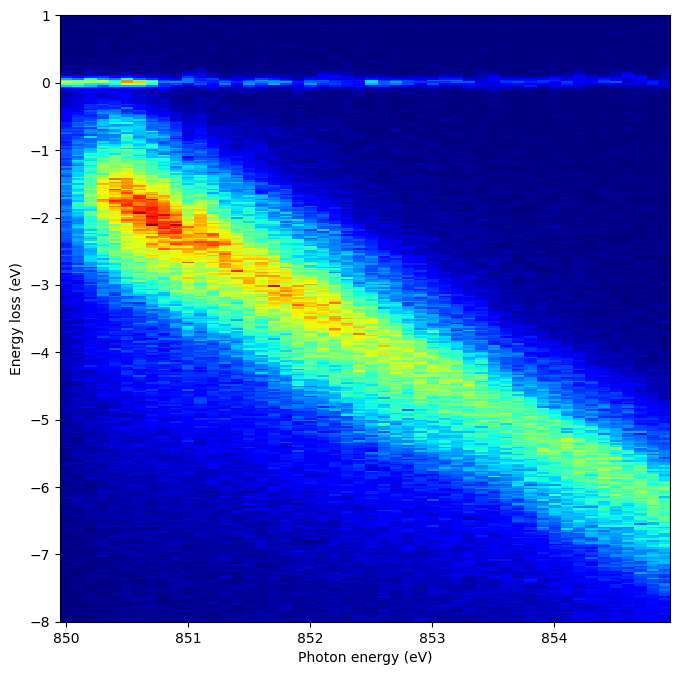

In [52]:
# plot
br.figure(figsize=(20,20))
im.plot()
br.labels.energy_map()
#plt.ylim(-8, 2)

# second alignmemnt
ss3 = ss.interp().align(mode='cc', limits = (-0.3, 0.3))
im3  = ss3.interp().stack_spectra_as_columns()
# im  = ss.interp().stack_spectra_as_columns()
im3.x_centers = energies

br.figure(figsize=(20,20))
im3.plot()
br.labels.energy_map()
plt.ylim(-8, 1)
# %%

'shift = -0.0010287547921499322'

'FWHM = 0.10863914723202636'

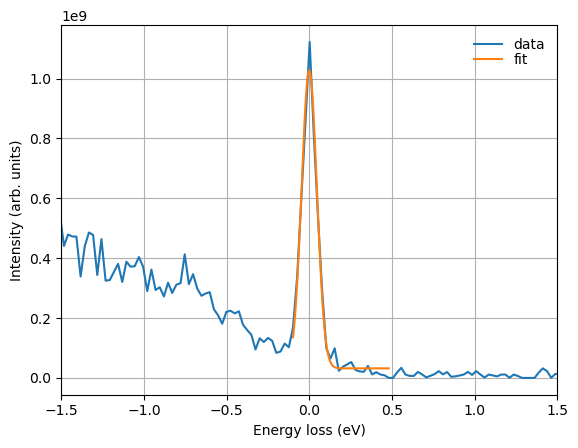

In [53]:
# fit the elastic peak
smooth, popt, err, f = ss3[0].fit_peak(limits=(-0.1, 0.5), fixed_m=0)
display(f'shift = {popt[1]}')
display(f'FWHM = {popt[2]}')

# plot
br.figure()
ss3[0].plot()
smooth.plot()
br.zoom(-1.5, 1.5)
br.leg(['data', 'fit'])
br.labels.rixs()

(-8.0, 1.0)

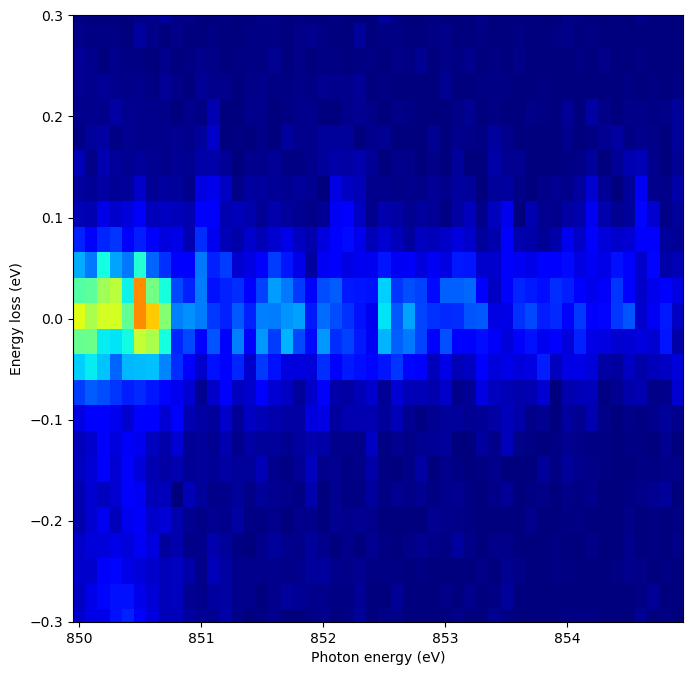

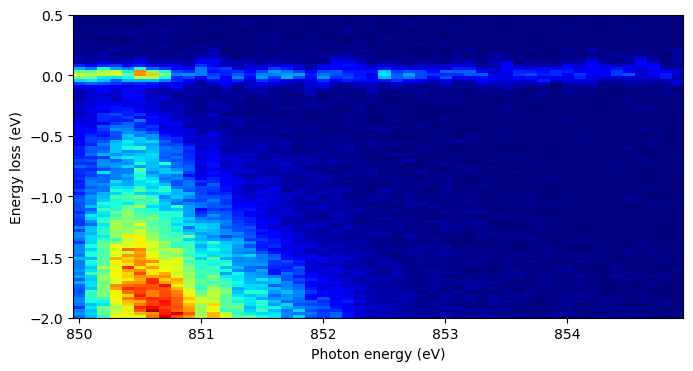

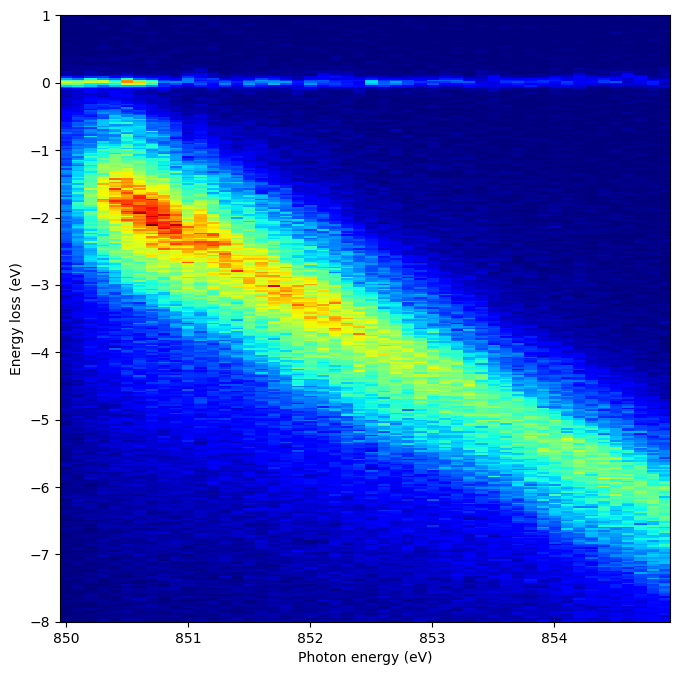

In [54]:
ss4 = ss3.set_shift(0.0010)
im4  = ss4.interp().stack_spectra_as_columns()
im4.x_centers = energies

br.figure(figsize=(20,20))
im4.plot()
br.labels.energy_map()
plt.ylim(-0.3, 0.3)

br.figure(figsize=(20,10))
im4.plot()
br.labels.energy_map()
plt.ylim(-2, 0.5)

br.figure(figsize=(20,20))
im4.plot()
br.labels.energy_map()
plt.ylim(-8, 1)
# %%

In [55]:
ss4.interp().save_all_single_file('out/S2mapL3LV.txt')
S2mapL3LV = ss4
np.savetxt('out/S2mapL3LV_x.txt',energies)

############# Eng of LV map #######################

In [155]:
DLD2 = RAW/'20251106_RIXS2.h5'
XAS2 = RAW/'20251106_scans2.h5'

In [57]:
# read scans
mask0 = ([1194, 7442, 2300, 3988], [1194, 7442, 4415, 6325])
time  = dict(tcutoff=3e7, tnbins=10000, period=1458, twidth=320, tcenter='max')
calib = 0.004024336330358059
sbins = 1200
parameters = dict(filepath=DLD2, mask=mask0, calib=calib, sbins=sbins)
parameters.update(**time)

scans = [269, 268, 267, *np.arange(217, 266+1)]

# let's pretend this scan sequence is a energy map
ss = br.Spectra()
energies = []  # uncomment this for real energy map 
grad = 1
for i, scan in enumerate(scans):
    curv = veritas.verify_curvature_correction(scan, DLD2, mask=mask0, nbins=nbins, **time, figsize=(25,15))
    plt.close()
    parameters.update(curv=curv)
    _s = veritas.process(scan, **parameters)
    if _s.exposure_time != 0:
        _s = _s.set_factor(_s.exposure_time)
    energies.append(round(_s.E, 2))  # uncomment this for real energy map
    _s = _s.set_shift(-13.7-(energies[i]-energies[0])*grad)
    _I0 = veritas.get_metadata(scan, DLD2, 'External/aemexp2_ch1/InstantCurrent')
    _I0 = np.mean(_I0[:, 1])
    _s = _s/_I0
    ss.append(_s)
    
# align spectra (sometimes, it must be done mannualy)
# ss2 = ss[i].set_shift(value)  # manually 
# for i, scan in enumerate(scans):
#    # ss2 = ss.interp().align(mode='seq', limits = (-0.5, 5)).set_shift(-13.16)
#    ss2 = ss.set_shift

# create image
# im  = ss2.interp().stack_spectra_as_columns()
im  = ss.interp().stack_spectra_as_columns()
im.x_centers = energies


In [39]:
ss3 = ss.interp().align(mode='cc', limits = (-0.3, 0.3))
ss3

0: <brixs.brixs.Spectrum object at 0x7f6440133aa0>
1: <brixs.brixs.Spectrum object at 0x7f643e0fd4f0>
2: <brixs.brixs.Spectrum object at 0x7f643e0fd730>
3: <brixs.brixs.Spectrum object at 0x7f643e0fd970>
4: <brixs.brixs.Spectrum object at 0x7f643e0fdbb0>
5: <brixs.brixs.Spectrum object at 0x7f643e0fddf0>
6: <brixs.brixs.Spectrum object at 0x7f643e0fe030>
7: <brixs.brixs.Spectrum object at 0x7f643e0fe270>
8: <brixs.brixs.Spectrum object at 0x7f643e0fe4b0>
9: <brixs.brixs.Spectrum object at 0x7f643e0fe6f0>
10: <brixs.brixs.Spectrum object at 0x7f643e0fe930>
11: <brixs.brixs.Spectrum object at 0x7f643e0feb70>
12: <brixs.brixs.Spectrum object at 0x7f643e0fedb0>
13: <brixs.brixs.Spectrum object at 0x7f643e0feff0>
14: <brixs.brixs.Spectrum object at 0x7f643e0ff230>
15: <brixs.brixs.Spectrum object at 0x7f643e0ff470>
16: <brixs.brixs.Spectrum object at 0x7f643e0ff6b0>
17: <brixs.brixs.Spectrum object at 0x7f643e0ff8c0>
18: <brixs.brixs.Spectrum object at 0x7f643e0ffb00>
19: <brixs.brixs.Spect

(-8.0, 1.0)

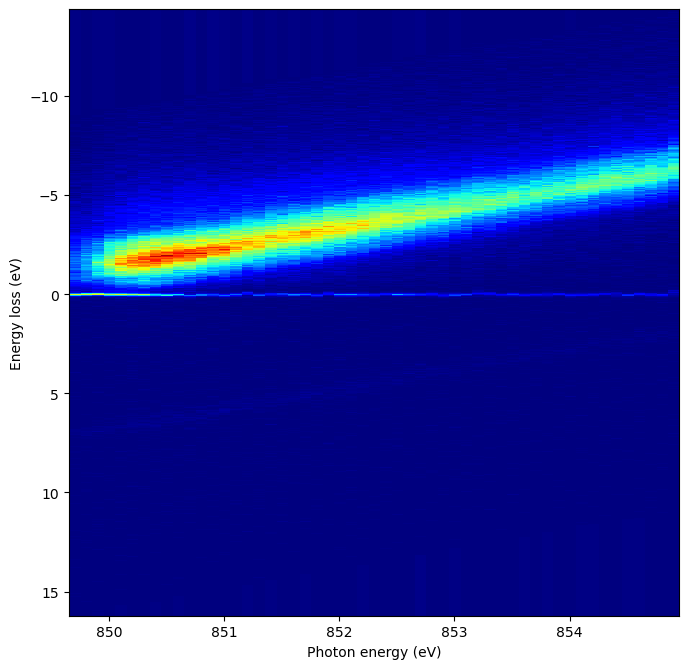

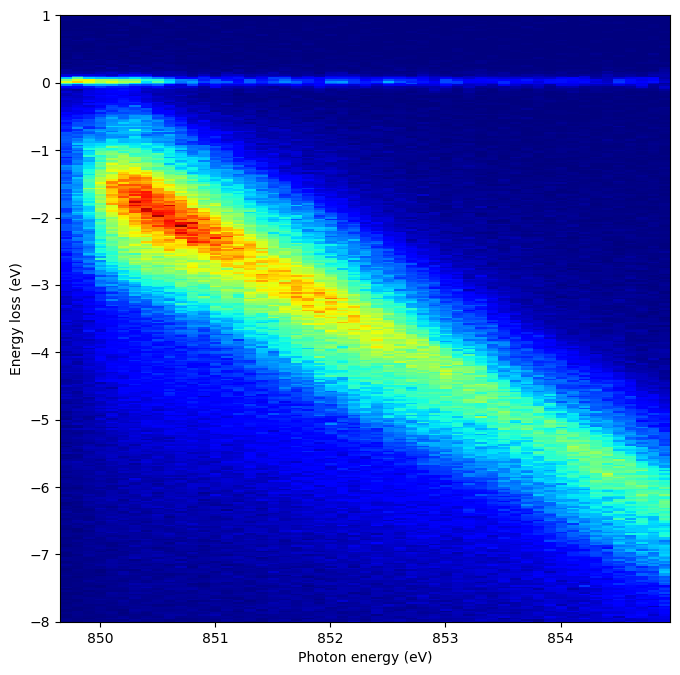

In [58]:
# plot
br.figure(figsize=(20,20))
im.plot()
br.labels.energy_map()
#plt.ylim(-8, 2)

# second alignmemnt
ss3 = ss.interp().align(mode='cc', limits = (-0.3, 0.3))
im3  = ss3.interp().stack_spectra_as_columns()
# im  = ss.interp().stack_spectra_as_columns()
im3.x_centers = energies

br.figure(figsize=(20,20))
im3.plot()
br.labels.energy_map()
plt.ylim(-8, 1)
# %%

'shift = 0.014639528549399629'

'FWHM = 0.09663625454239802'

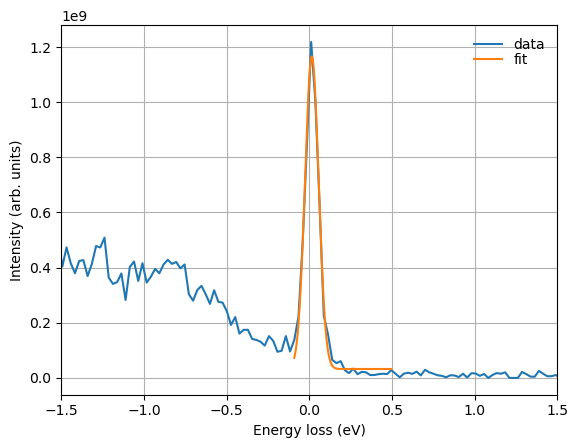

In [59]:
# fit the elastic peak
smooth, popt, err, f = ss3[0].fit_peak(limits=(-0.1, 0.5), fixed_m=0)
display(f'shift = {popt[1]}')
display(f'FWHM = {popt[2]}')

# plot
br.figure()
ss3[0].plot()
smooth.plot()
br.zoom(-1.5, 1.5)
br.leg(['data', 'fit'])
br.labels.rixs()

(-8.0, 1.0)

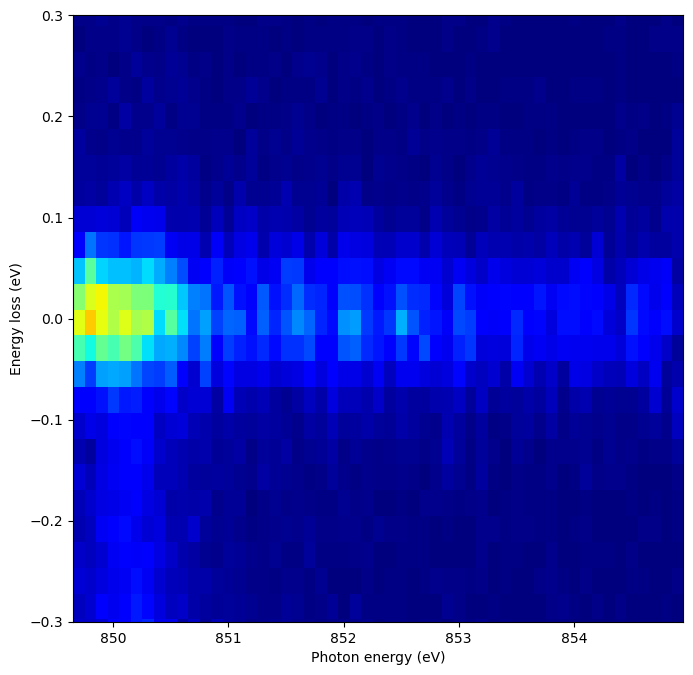

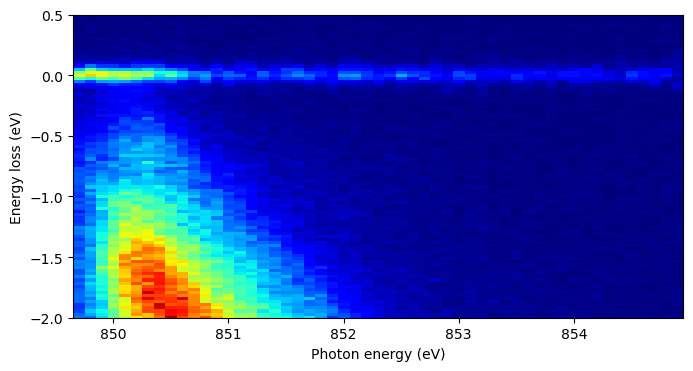

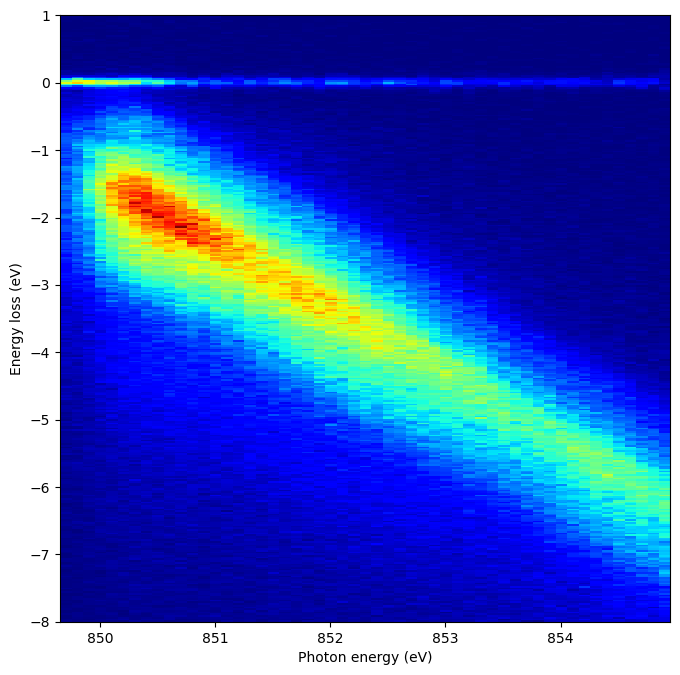

In [60]:
ss4 = ss3.set_shift(-0.0146)
im4  = ss4.interp().stack_spectra_as_columns()
im4.x_centers = energies

br.figure(figsize=(20,20))
im4.plot()
br.labels.energy_map()
plt.ylim(-0.3, 0.3)

br.figure(figsize=(20,10))
im4.plot()
br.labels.energy_map()
plt.ylim(-2, 0.5)

br.figure(figsize=(20,20))
im4.plot()
br.labels.energy_map()
plt.ylim(-8, 1)
# %%

In [61]:
ss4.interp().save_all_single_file('out/S2mapL3LH.txt')
S2mapL3LH = ss4
np.savetxt('out/S2mapL3LH_x.txt',energies)

################## Here ends the LH map #######################

(-8.0, 1.0)

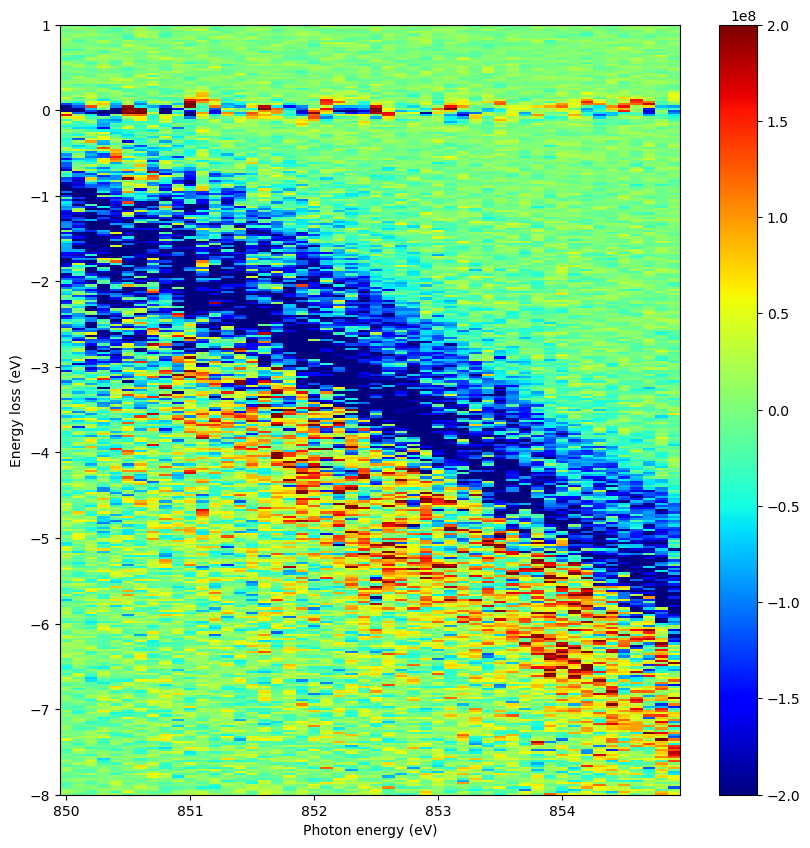

In [142]:
S2mapL3diffln = br.Spectra()
scans = [*np.arange(166, 175+1), *[216], *np.arange(177, 215+1)]
energies = []  # uncomment this for real energy map 
for i, scan in enumerate(scans):
    _s = veritas.read(scan, DLD)
    energies.append(round(_s.E, 2))  # uncomment this for real energy map

for i, _energy in enumerate(energies):
    _ss = br.Spectra()
    _ss.append(S2mapL3LV[i])
    _ss.append(S2mapL3LH[i+1])
    _ss = _ss.interp()
    _s = _ss[0] - _ss[1]
    S2mapL3diffln.append(_s)

im  = S2mapL3diffln.interp().stack_spectra_as_columns()
im.x_centers = energies

# plot
fig = plt.figure(figsize=(10, 10))
_ = im.binning(ncols=None, nrows=None).plot()
plt.clim(-2e8, 2e8)
fig.colorbar(_)
br.labels.energy_map()
plt.ylim(-8, 1)
# %%

In [138]:
help(_s1.set_offset)

Help on method set_offset in module brixs.brixs:

set_offset(value) method of brixs.brixs.Spectrum instance
    Add value to y-coordinates.

    Args:
        value (value): offset value.

    Returns:
        :py:class:`Spectrum`



In [132]:
dir(_s1)

['E',
 'E_max',
 'E_min',
 'E_sigma',
 'T',
 'T_max',
 'T_min',
 'T_sigma',
 '__add__',
 '__class__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_calib',
 '_check_limits',
 '_copy',
 '_factor',
 '_get_methods',
 '_has_nan',
 '_monotonicity',
 '_offset',
 '_shift',
 '_step',
 '_x',
 '_y',
 'append',
 'arm_energy',
 'arm_energy_max',
 'arm_energy_min',
 'arm_energy_sigma',
 'calculate_area',
 'calculate_calib',
 'calculate_folded_time',
 'calculate_x_average',
 'calculate_x_sum',
 'calculate_y_average',
 'calculate_y_sum',
 'calib',
 'ch

(-8.0, 1.0)

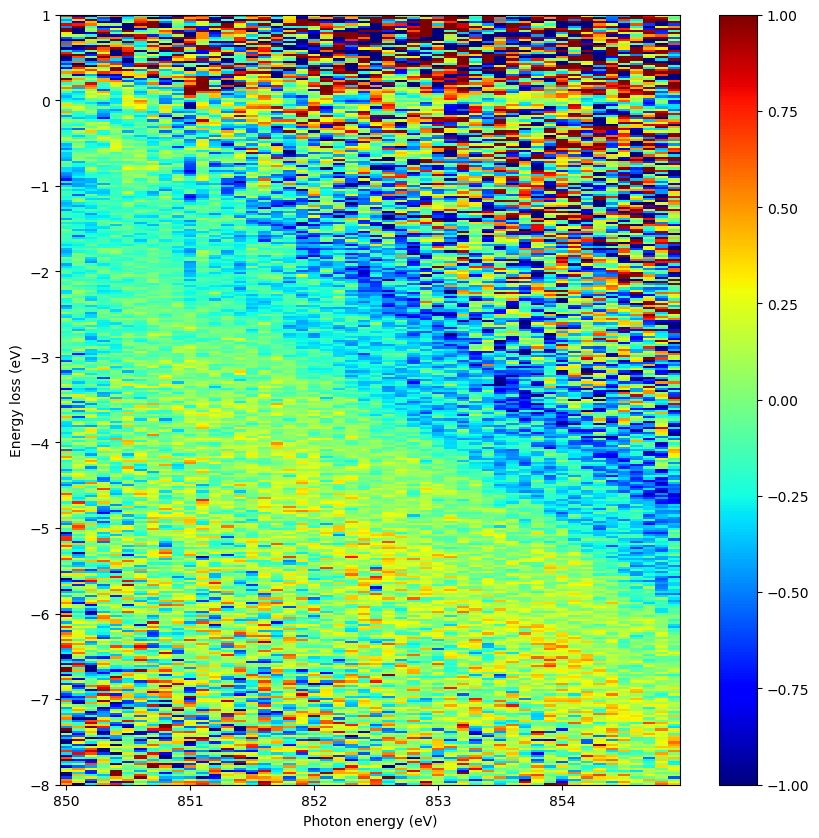

In [148]:
S2mapL3diffln2 = br.Spectra()
scans = [*np.arange(166, 175+1), *[216], *np.arange(177, 215+1)]
energies = []  # uncomment this for real energy map 
for i, scan in enumerate(scans):
    _s = veritas.read(scan, DLD)
    energies.append(round(_s.E, 2))  # uncomment this for real energy map

for i, _energy in enumerate(energies):
    _ss = br.Spectra()
    _ss.append(S2mapL3LV[i])
    _ss.append(S2mapL3LH[i+1])
    _ss = _ss.interp()
    _s1 = _ss[0] - _ss[1]
    _s2 = (_ss[0] + _ss[1])/2
    _s2 = _s2.set_offset(1e-100)
    _s = _s1/_s2
    S2mapL3diffln2.append(_s)

im  = S2mapL3diffln2.interp().stack_spectra_as_columns()
im.x_centers = energies

# plot
fig = plt.figure(figsize=(10, 10))
_ = im.binning(ncols=None, nrows=None).plot()
plt.title(r'(LV-LH)/((LV+LH)/2)')
plt.clim(-1, 1)
fig.colorbar(_)
br.labels.energy_map()
plt.ylim(-8, 1)
# %%

In [66]:
S2mapL3diffln.interp().save_all_single_file('out/S2mapL3diffln.txt')
np.savetxt('out/S2mapL3diffln_x.txt',energies)